# Exercise Sheet 6

## 1. Visualization of AOs and MOs

In [2]:
import pyscf
from pyscf import scf
import numpy as np
import matplotlib.pyplot as plt

In [7]:
HF = [["H", (0, 0, 0)], ["F", (0, 0, 0.917)]]

mol = pyscf.M(atom=HF, unit="angstrom", basis="6-31G(d,p)")

N = 100
points = np.linspace(-2, 2, N)
X, Y, Z = np.meshgrid(points, points, points)

coords = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

ao_value = mol.eval_gto("GTOval", coords)
ao_value = ao_value.reshape(N, N, N, -1)
print(ao_value.shape)

(100, 100, 100, 19)


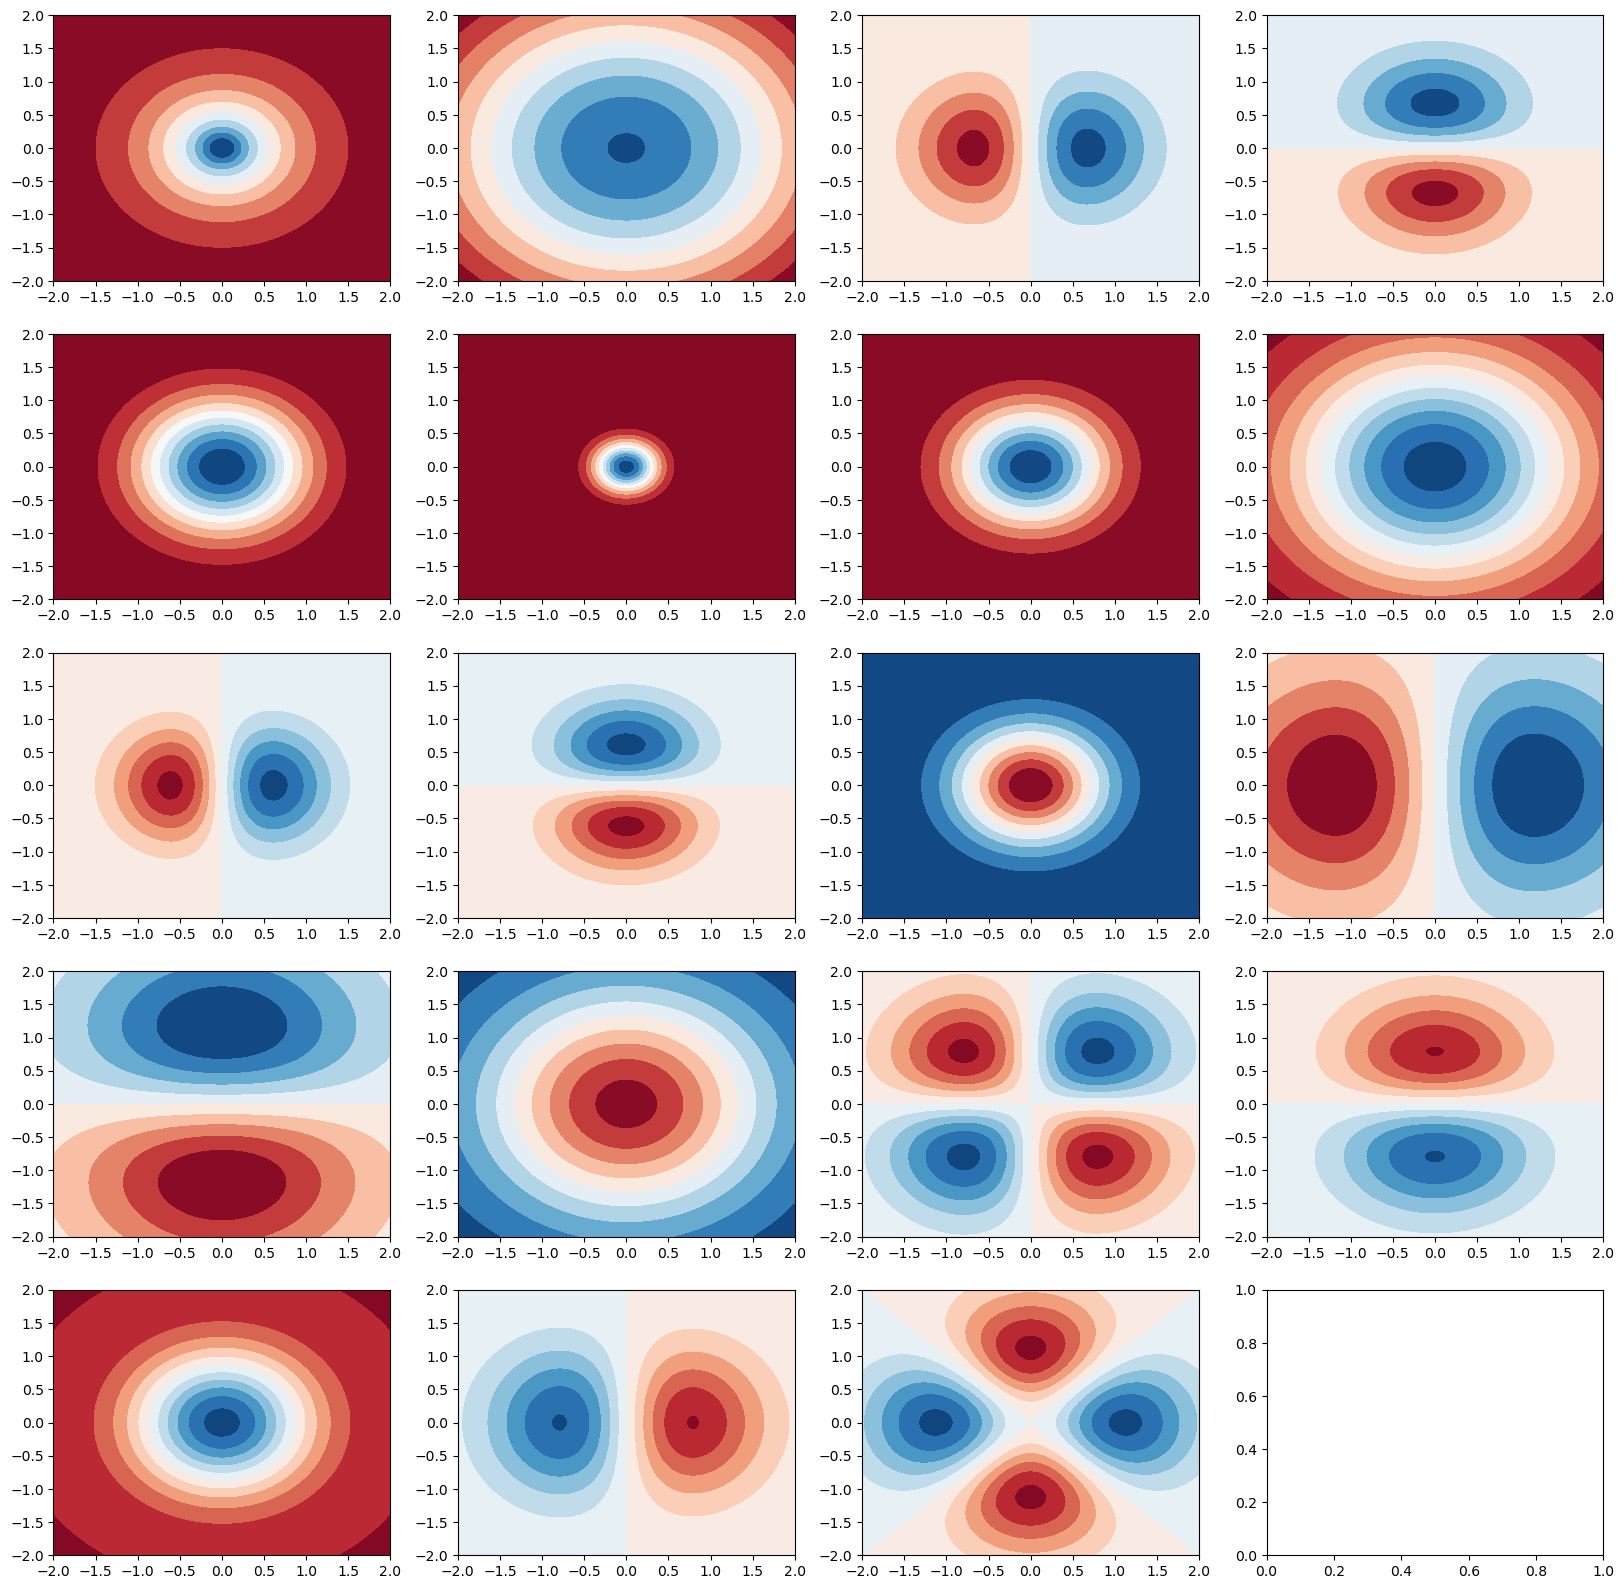

In [89]:
fig, ax = plt.subplots(5, 4, figsize=(20, 20))
# Atomic orbitals
for i in range(5):
    for j in range(4):
        if i * 4 + j >= ao_value.shape[-1]:
            break
        ax[i, j].contourf(
            X[:, :, 0],
            Y[:, :, 0],
            ao_value[:, :, N // 2, i * 4 + j],
            levels=10,
            cmap="RdBu",
        )

converged SCF energy = -100.009878770347


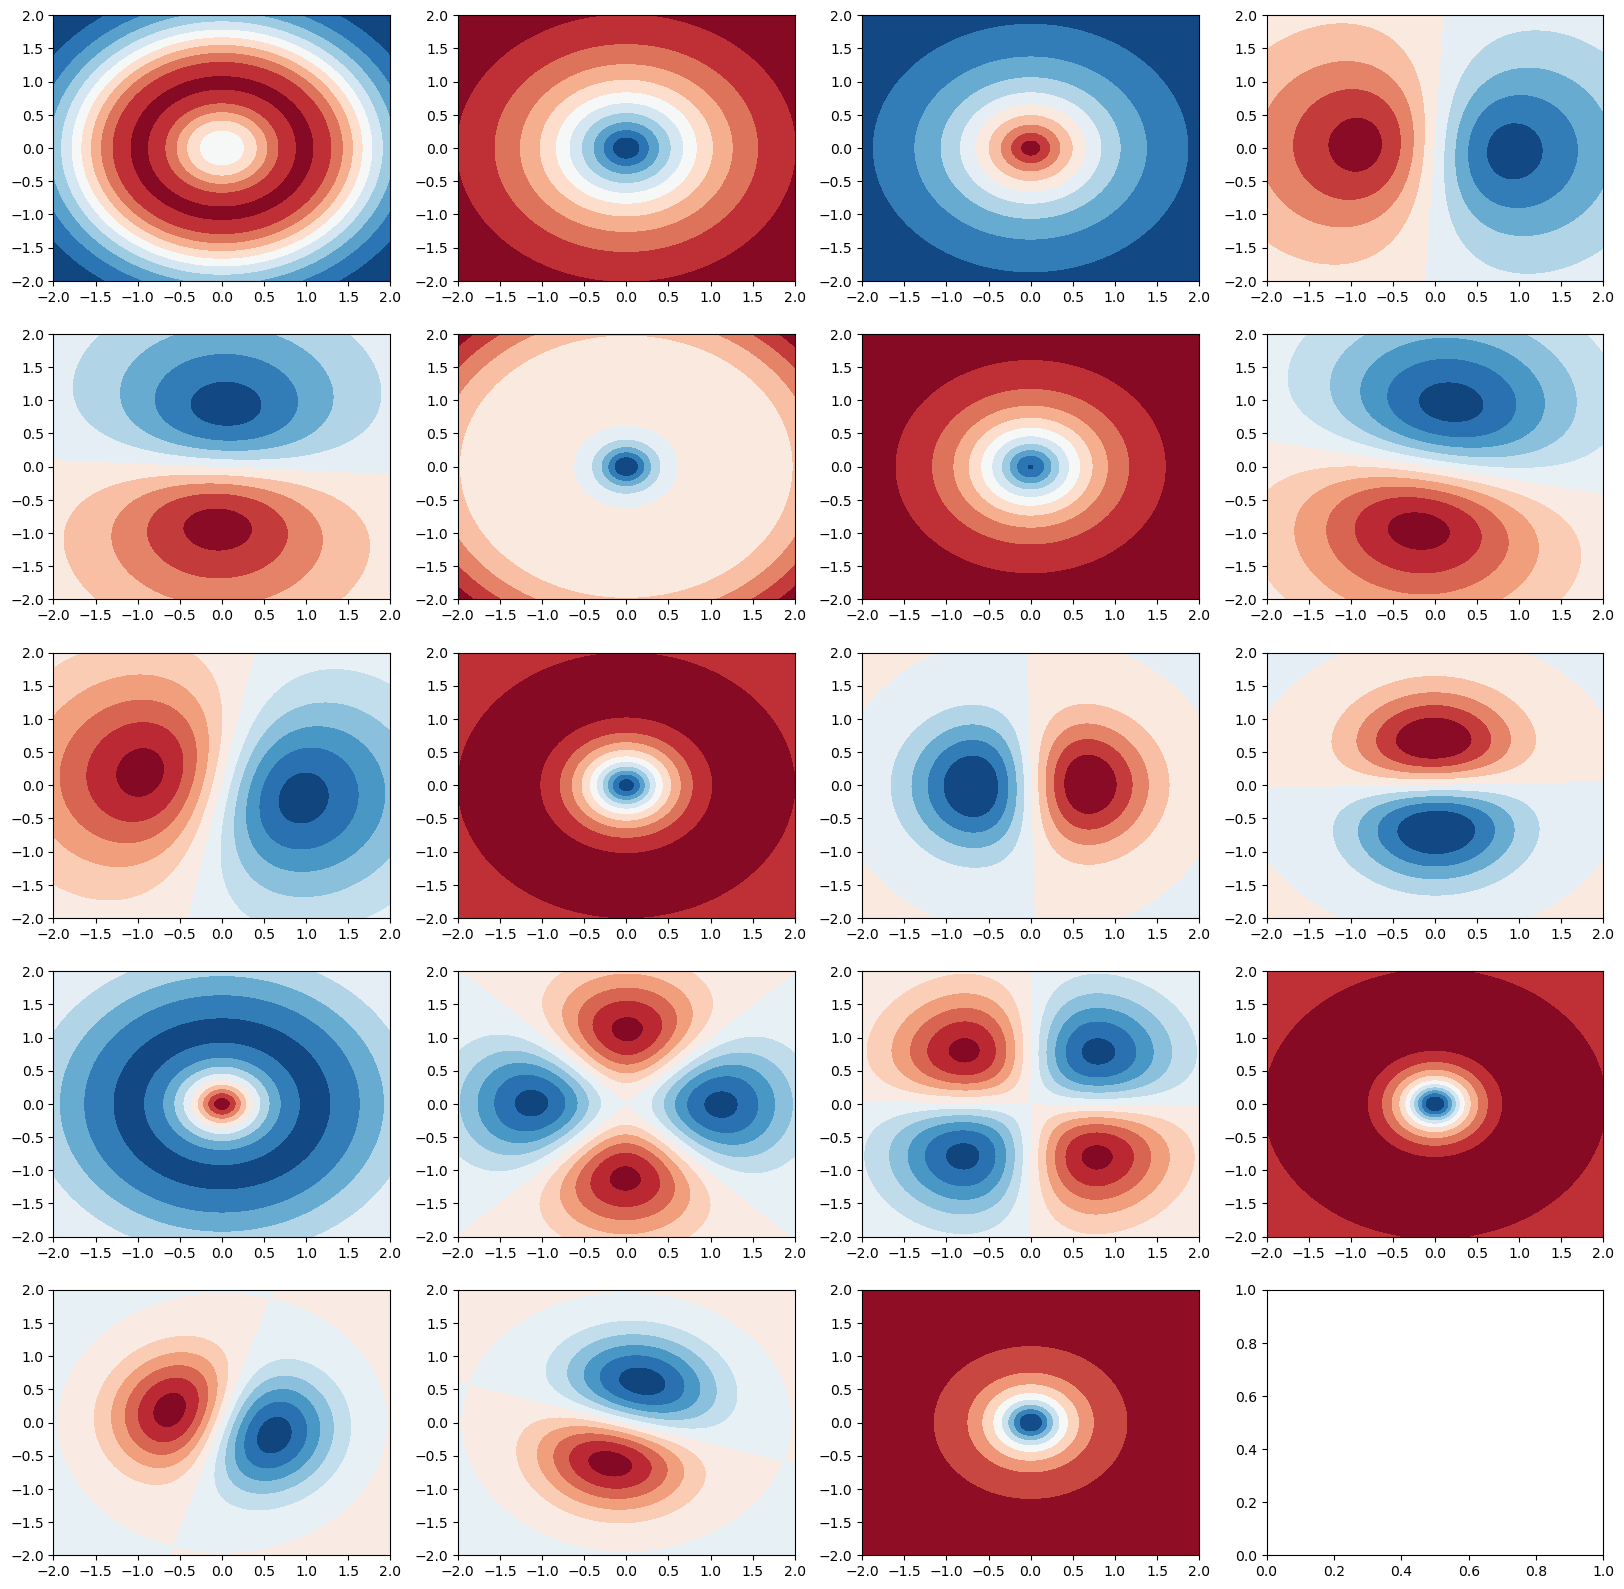

In [62]:
hf = scf.RHF(mol)
hf.kernel()
mo_coeff = hf.mo_coeff

fig, ax = plt.subplots(5, 4, figsize=(20, 20))
for i in range(5):
    for j in range(4):
        if i * 4 + j >= ao_value.shape[-1]:
            break
        mo_grid = np.dot(ao_value, mo_coeff[:, i * 4 + j]).reshape(N, N, N)
        ax[i, j].contourf(
            X[:, :, 0], Y[:, :, 0], mo_grid[:, :, N // 2], levels=10, cmap="RdBu"
        )

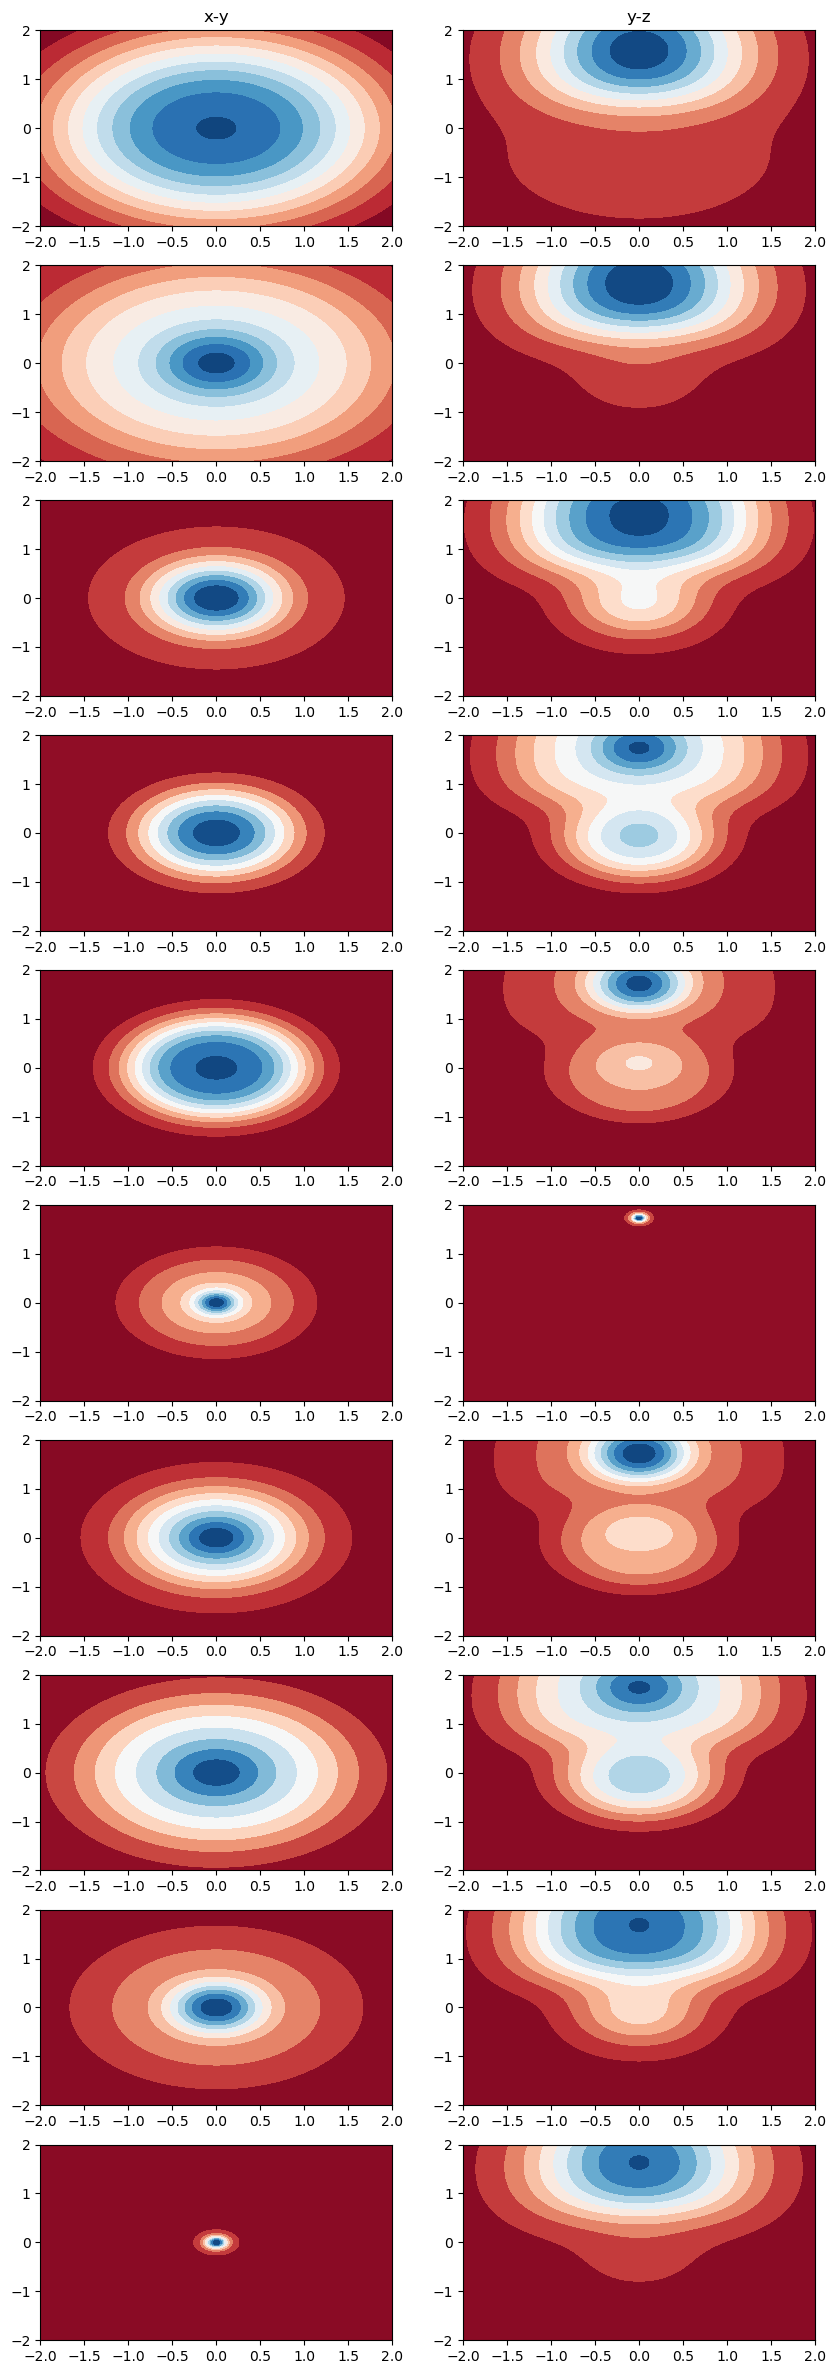

In [123]:
elec_d = np.sum(np.dot(ao_value, mo_coeff) ** 2, axis=-1)

fig, ax = plt.subplots(10, 2, figsize=(10, 30))
ax[0, 0].set_title("x-y")
ax[0, 1].set_title("y-z")

for i in range(10):
    ax[i, 0].contourf(
        X[:, :, 0], Y[:, :, 0], elec_d[:, :, i * N // 10], levels=10, cmap="RdBu"
    )
    ax[i, 1].contourf(
        Y[:, 0, :], Z[:, 0, :], elec_d[:, i * N // 10, :], levels=10, cmap="RdBu"
    )
plt.show()

# 2. PCA on Fock Matrix

In [170]:
from pyscf import gto, scf

mol = gto.Mole()
mol.atom = """
O        0.000000    0.000000    0.117790
H        0.000000    0.755453   -0.471161
H        0.000000   -0.755453   -0.471161"""
mol.basis = "6-31G(2df,p)"
mol.build()

In [171]:
def make_callback(storage):
    def callback(envs):
        f = envs["fock"]
        upper = f[np.triu_indices(f.shape[0])]
        storage.append(upper)

    return callback

In [172]:
# Hartree-Fock, no DIIS, no damping
focks_00 = []
hf = scf.HF(mol)
hf.callback = make_callback(focks_00)
hf.diis = False
e = hf.kernel()
print(f"E: {e}")
print(f"{len(focks_00)} cycles")

converged SCF energy = -76.0259626971755
E: -76.0259626971755
19 cycles


In [173]:
# Hartree-Fock, DIIS, damping
focks_11 = []
hf = scf.HF(mol)
hf.callback = make_callback(focks_11)
hf.diis = True
hf.diis_damp = 0.1
e = hf.kernel()
print(f"E: {e}")
print(f"{len(focks_11)} cycles")

converged SCF energy = -76.0259626972048
E: -76.0259626972048
8 cycles


In [174]:
# Hartree-Fock, DIIS, no damping
focks_10 = []
hf = scf.HF(mol)
hf.callback = make_callback(focks_10)
hf.diis = True
hf.diis_damp = 0
e = hf.kernel()
print(f"E: {e}")
print(f"{len(focks_10)} cycles")

converged SCF energy = -76.0259626972054
E: -76.02596269720543
8 cycles


In [175]:
# Hartree-Fock, no DIIS, damping
focks_01 = []
hf = scf.HF(mol)
hf.callback = make_callback(focks_01)
hf.diis = True
hf.diis_start_cycle = 10**10
hf.diis_damp = 0.1
e = hf.kernel()
print(f"E: {e}")
print(f"{len(focks_01)} cycles")

converged SCF energy = -76.0259626971755
E: -76.02596269717552
19 cycles


Fock matrix is symmetric, thus we only need the elements with indices i<=j

In [176]:
from sklearn.decomposition import PCA


def plot_pca(vectors, title=None):
    pca = PCA(n_components=2)
    vectors_pca = pca.fit_transform(vectors)

    plt.figure(figsize=(10, 10))
    plt.plot(vectors_pca[:, 0], vectors_pca[:, 1], marker="o", linestyle="-", color="b")
    if title:
        plt.title(title)
    plt.show()

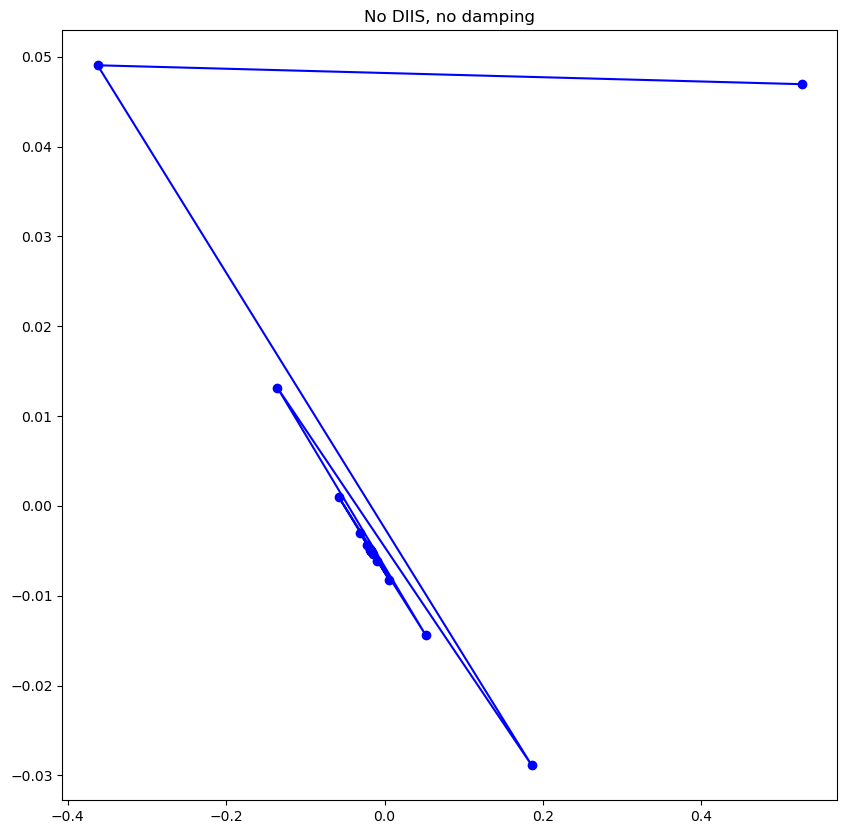

In [177]:
plot_pca(focks_00, "No DIIS, no damping")

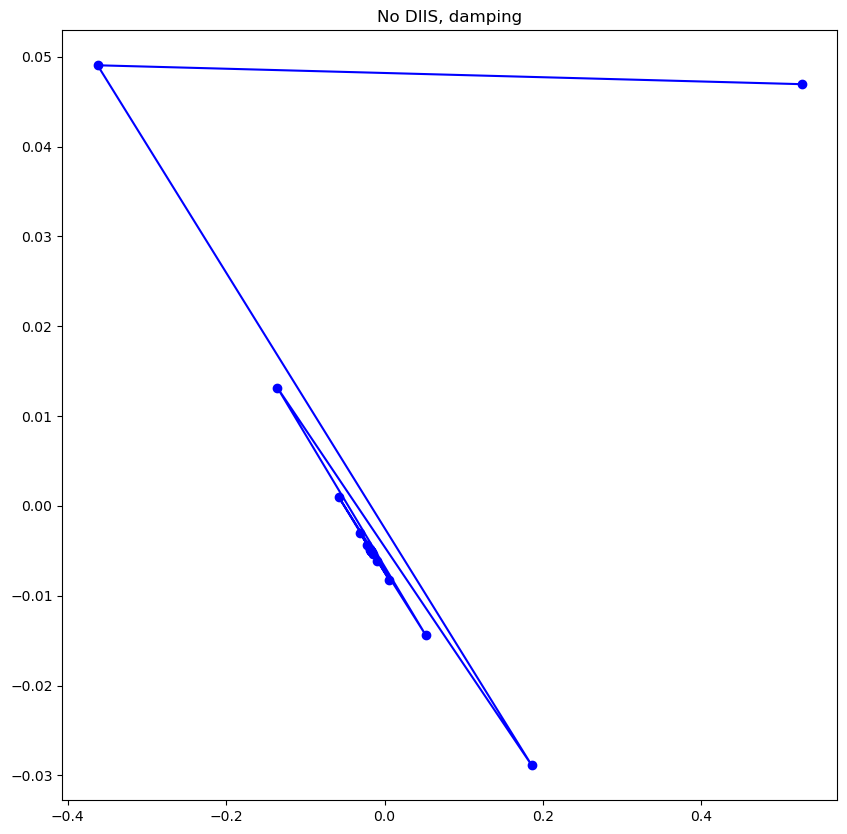

In [178]:
plot_pca(focks_01, "No DIIS, damping")

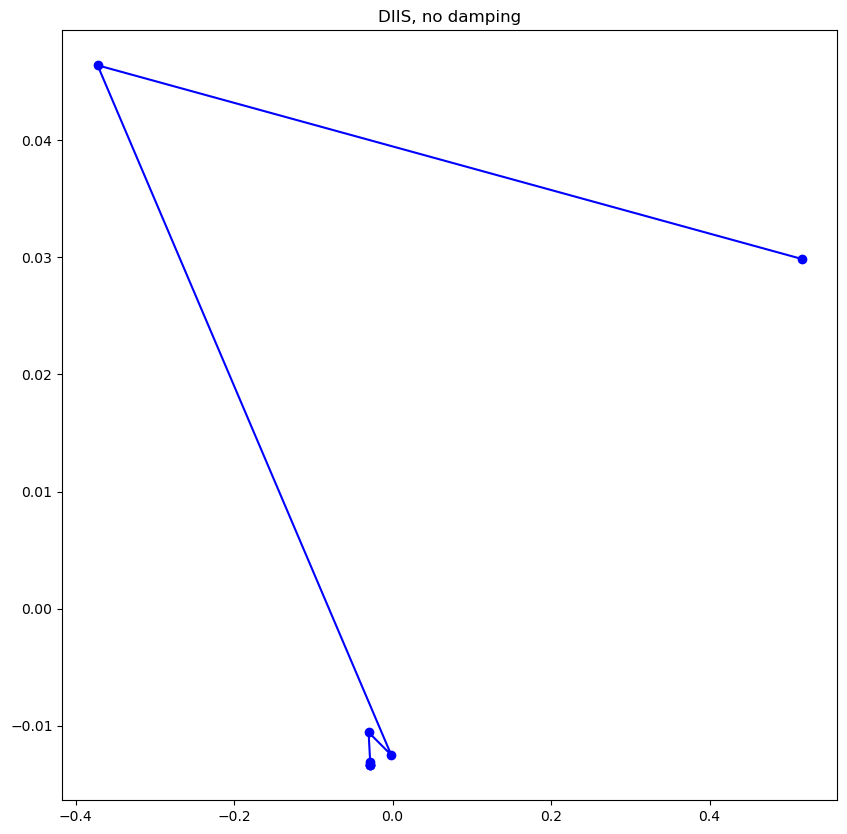

In [179]:
plot_pca(focks_10, "DIIS, no damping")

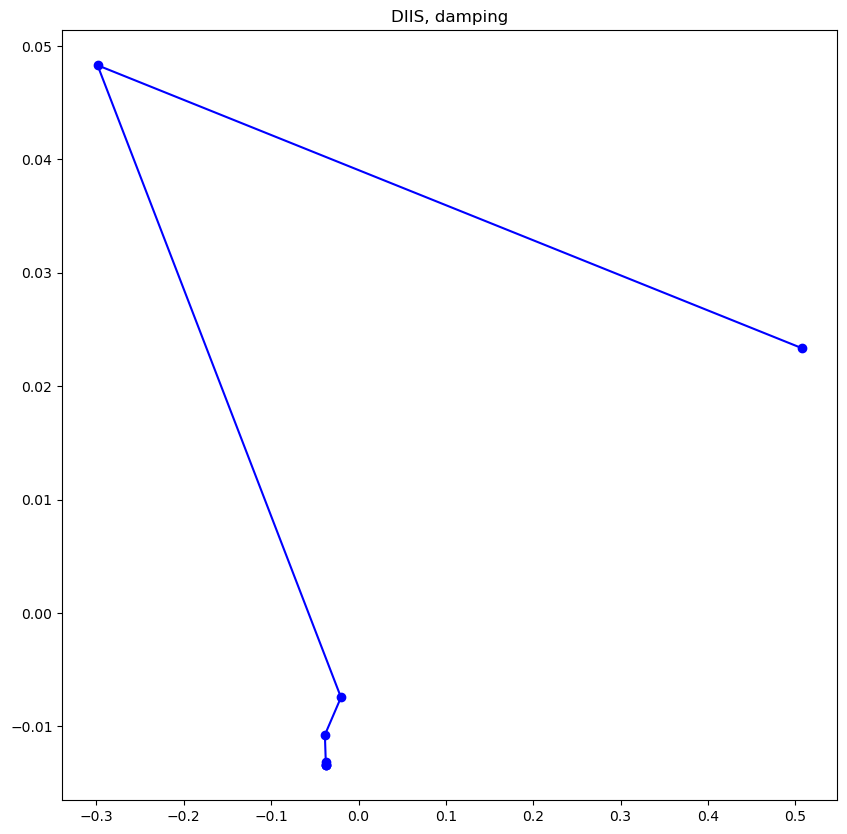

In [180]:
plot_pca(focks_11, "DIIS, damping")


In case of DIIS, damping reduces zig-zagging. In case of no DIIS, it isn't really noticeable, since DIIS gives the biggets convergence boost